# Hate Speech detection using Transformers (CNN)

In [ ]:
!pip install transformers pandas numpy torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.5 MB/s eta 0:00:00


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score,accuracy_score


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [ ]:
# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load dataset
df = pd.read_csv('labeled_data.csv')
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
# check the shape of the data
print(df.shape)

# check for missing values
print(df.isnull().sum())

(24783, 7)
Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64


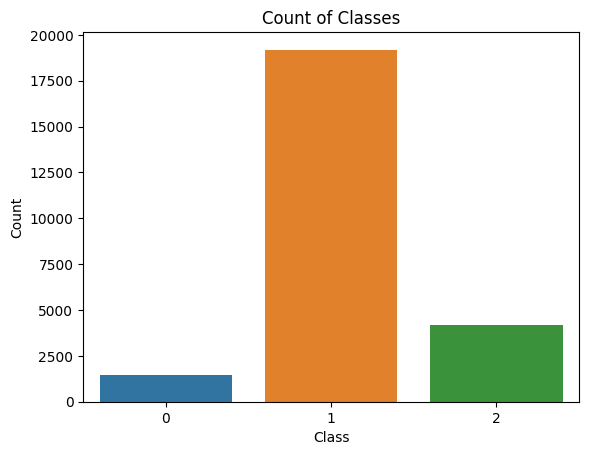

In [ ]:
# Check the distribution of class labels
sns.countplot(x='class',data=df)
plt.title('Count of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


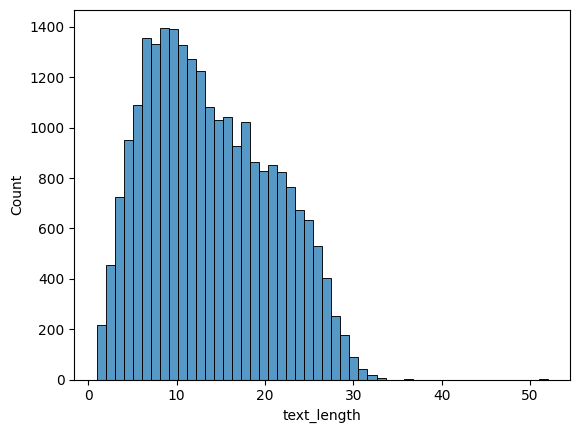

In [ ]:
# Check the distribution of text length
df['text_length'] = df['tweet'].apply(lambda x: len(x.split()))
sns.histplot(df['text_length'], bins=50)
plt.show()

In [ ]:
# Print some random tweets
print("Some tweets with class 0:")
print(df[df['class'] == 0].sample(5)['tweet'])
print("\nSome tweets with class 1:")
print(df[df['class'] == 1].sample(5)['tweet'])
print("\nSome tweets with class 2:")
print(df[df['class'] == 2].sample(5)['tweet'])

Some tweets with class 0:
2499     @AustinG1135 I do not like talking to you fagg...
19697    RT @mitchmancuso: @BrantPrintup:What straight ...
5749     @clinchmtn316 @sixonesixband AMERICA today, th...
4615                   @STACCS_WNT_FOLD you tell me, coon.
15140             RT @FAAMMoverALL: This nigguh Chris Paul
Name: tweet, dtype: object

Some tweets with class 1:
2941     @D_Palomino52 you a poop. :( see I'm going all...
20018    RT @silent_musings: Over-thinking can and will...
5501                @alizahwi Make yo bitch open her legs.
8595     Daaamn lmao right back to them old ways RT @Ki...
12025    Jada Fire has never dropped me for talking to ...
Name: tweet, dtype: object

Some tweets with class 2:
4525     @RetroReasoning I think most RPGs are for the ...
10605    I just want some Oreos &amp; milk honestly. Ju...
7838     At a point where I've got to make a tough life...
2146     *after BO1 RT @TheGodWriter_: @iDocLyfe Bruh l...
5010                  @ToWherever I'm no

In [ ]:
# Define stop words to be removed from text
stop_words = set(stopwords.words('english'))
stop_words.add('and') 

# Define lemmatizer
lemmatizer = WordNetLemmatizer()


In [ ]:
def preprocess_text(text):
    # Tokenize text
    text = re.sub(r'http', '', text)
    tokens = word_tokenize(text)
    
    # Remove stop words
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words]
    
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join tokens back into text
    processed_text = ' '.join(tokens)
    
    return processed_text

In [ ]:
df['tweet'] = df['tweet'].apply(preprocess_text)

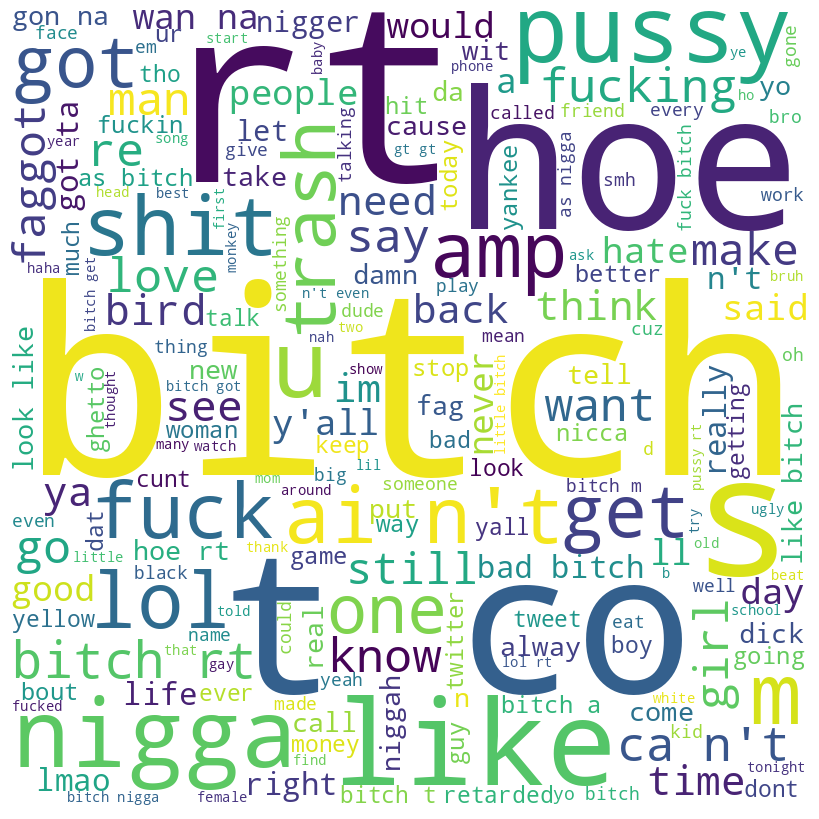

In [ ]:
# plot a wordcloud of the tweets
from wordcloud import WordCloud

words = ' '.join(df['tweet'])
wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      stopwords = set(), 
                      min_font_size = 10).generate(words) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [ ]:
# Split data into train, validation, and test sets
train_df, val_df, test_df = np.split(df.sample(frac=1, random_state=42), [int(0.7 * len(df)), int(0.9 * len(df))])

In [ ]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


In [ ]:
# Define function to tokenize and encode text data
def tokenize_and_encode_text(text, tokenizer, max_length):
    # Tokenize text
    tokenized_text = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_length,
                                            pad_to_max_length=True, return_attention_mask=True)
    # Return input ids and attention mask
    return tokenized_text['input_ids'], tokenized_text['attention_mask']

In [ ]:
# Tokenize and encode text data for train set
train_input_ids = []
train_attention_masks = []

for text in train_df['tweet']:
    input_ids, attention_mask = tokenize_and_encode_text(text, tokenizer, max_length=128)
    train_input_ids.append(input_ids)
    train_attention_masks.append(attention_mask)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Convert data to tensors
train_input_ids = torch.tensor(train_input_ids)
train_attention_masks = torch.tensor(train_attention_masks)
train_labels = torch.tensor(train_df['class'].values)


In [ ]:
# Create TensorDataset
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)

In [ ]:
# Tokenize and encode text data for validation set
val_input_ids = []
val_attention_masks = []

for text in val_df['tweet']:
    input_ids, attention_mask = tokenize_and_encode_text(text, tokenizer, max_length=128)
    val_input_ids.append(input_ids)
    val_attention_masks.append(attention_mask)

# Convert data to tensors
val_input_ids = torch.tensor(val_input_ids)
val_attention_masks = torch.tensor(val_attention_masks)
val_labels = torch.tensor(val_df['class'].values)

# Create TensorDataset
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)


In [ ]:
# Tokenize and encode text data for test set
test_input_ids = []
test_attention_masks = []

for text in test_df['tweet']:
    input_ids, attention_mask = tokenize_and_encode_text(text, tokenizer, max_length=128)
    test_input_ids.append(input_ids)
    test_attention_masks.append(attention_mask)

# Convert data to tensors
test_input_ids = torch.tensor(test_input_ids)
test_attention_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_df['class'].values)

# Create TensorDataset
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# Define test sampler and data loader
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)


In [ ]:
from transformers import BertForSequenceClassification

# Initialize model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Switch model to evaluation mode
model.eval()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
all_predictions = []

for batch in test_dataloader:
    batch_input_ids, batch_attention_masks, batch_labels = batch
    batch_input_ids = batch_input_ids.to(device)
    batch_attention_masks = batch_attention_masks.to(device)
    batch_labels = batch_labels.to(device)

    with torch.no_grad():
        outputs = model(batch_input_ids, attention_mask=batch_attention_masks)

    logits = outputs[0]
    predictions = torch.argmax(logits, dim=1)
    all_predictions.extend(predictions.cpu().detach().numpy())


In [ ]:

all_predictions = torch.cat([torch.tensor(pred).unsqueeze(0) for pred in all_predictions], dim=0)


In [ ]:
f1 = f1_score(test_labels, all_predictions, average='weighted')
print(f"F1 score: {f1}")


F1 score: 0.1212695699020672


In [ ]:
accuracy = accuracy_score(test_labels, all_predictions)
print(f"Accuracy: {accuracy}")

conf_matrix = confusion_matrix(test_labels, all_predictions)
print(f"Confusion matrix:\n{conf_matrix}")


Accuracy: 0.14078257361839452
Confusion matrix:
[[  64    8   52]
 [ 814  106 1022]
 [ 220   14  179]]
